**Translate PySR equations into physical form**

In [7]:
import sympy as sp
import numpy as np
import json
import os

In [8]:
# Choose between 1,2,3,4
regime = 4

In [9]:
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

all_possible_features = ['hus', 'qc', 'qi', 't', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i

In [10]:
rh, t, qc, qi, rh_z, rh_zz, pa_zz, ps = sp.symbols('rh t qc qi rh_z rh_zz pa_zz ps')

# Based on the regime the features have different meanings
if regime == 1:
    features = ['qi', 'rh', 't', 'rh_z', 'rh_zz']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (qi - mean[0])/std[0]
    x1 = (rh - mean[1])/std[1]
    x2 = (t - mean[2])/std[2]
    x3 = (rh_z - mean[3])/std[3]
    x4 = (rh_zz - mean[4])/std[4]
    
elif regime == 2:
    features = ['qi', 'qc', 'rh', 'rh_z', 'pa_zz']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (qi - mean[0])/std[0]
    x1 = (qc - mean[1])/std[1]
    x2 = (rh - mean[2])/std[2]
    x3 = (rh_z - mean[3])/std[3]
    x4 = (pa_zz - mean[4])/std[4]
    
elif regime == 3:
    features = ['rh', 't', 'rh_z', 'ps', 'rh_zz']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (rh - mean[0])/std[0]
    x1 = (t - mean[1])/std[1]
    x2 = (rh_z - mean[2])/std[2]
    x3 = (ps - mean[3])/std[3]
    x4 = (rh_zz - mean[4])/std[4]
    
elif regime == 4:
    features = ['rh', 'rh_z', 'pa_zz', 'rh_zz', 'qc']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (rh - mean[0])/std[0]
    x1 = (rh_z - mean[1])/std[1]
    x2 = (pa_zz - mean[2])/std[2]
    x3 = (rh_zz - mean[3])/std[3]
    x4 = (qc - mean[4])/std[4]

**Plot distributions of predictions and compute the Hellinger score for four candidate equations per regime**

In [11]:
## Load data
path_data = os.path.join('/home/b/b309170/', 'my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

# Split into cloud regimes
cod_subs = input_data[:, loc_all['qi']] + input_data[:, loc_all['qc']]
cod_subs_med = np.median(cod_subs[cod_subs != 0])

pa_med = np.median(input_data[cod_subs != 0, loc_all['pa']])

## For the training data
input_data_reg_1 = input_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
input_data_reg_2 = input_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]
input_data_reg_3 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
input_data_reg_4 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]

output_data_reg_1 = output_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
output_data_reg_2 = output_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]
output_data_reg_3 = output_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
output_data_reg_4 = output_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]

# Do the regimes have a similar size?
for i in range(1, 5):
    print(locals()['input_data_reg_%d'%i].shape)
    print(locals()['output_data_reg_%d'%i].shape)
    
## Keeping only the relevant features and the appropriate regime
inds = [loc_all[feat] for feat in features]
input_data = locals()['input_data_reg_%d'%regime][:, inds]
output_data = locals()['output_data_reg_%d'%regime]

# Update loc
loc = {}
for i in range(len(features)):
    loc[features[i]] = i

(58421418, 24)
(58421418,)
(35374362, 24)
(35374362,)
(35374356, 24)
(35374356,)
(58421401, 24)
(58421401,)


In [30]:
# Number of samples in the condensate-free regime
samples_total - 58421418*2 - 35374362*2

97587934

In [12]:
def cube(x):
    return x**3

def exp(x):
    return sp.exp(x)

In [13]:
# See also grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec3_data-driven_modeling/sec33_symbolic_regression_fits/pysr_results/read_results.ipynb

# Equations copied manually from the hof files.
if regime == 1:
    # tmp20m0tjio (2 hour PySR run)
    eq_1 = ((((x1 * 1.3106004) - -1.1215717) - x2) * (((((x1 - -0.6921713) * x1) - 1.7383649) / (x0 - -0.36915675)) + 42.141277)) #15
    eq_2 = ((((x1 * 1.306444) - -1.1760198) - x2) * ((x3 * -1.9334707) + (((((x1 * (x2 - -1.8897678)) * x1) - 2.2833774) / (x0 - -0.38175905)) + 42.141277))) #18
    eq_3 = ((((x1 * 1.3021564) - -1.1323451) - x2) * ((((1.551526 - x4) - x3) * (0.5124828 - x3)) + (((((x1 * (x2 - -1.8496528)) * x1) - 2.2833774) / (x0 - -0.38175905)) + 42.141277))) #21
    eq_4 = (((x1 - -1.1366048) - x2) * ((x1 * ((x1 - (x2 * (x0 + (x0 - -0.3500207)))) * 14.167247)) + ((x3 * (((x4 + -0.5412056) + x3) * ((3.9946866 - x1) + x4))) + (((x1 - 1.8120887) / (x0 - -0.37567925)) + 39.724678)))) #25  
elif regime == 2:
    # tmpmiqpx6bv (2 hour PySR run)
    eq_1 = ((x3 * (((x3 - (x0 * 6.799734)) * 1.7811792) - x4)) + ((-2.3767745 / (x0 + (x1 + 0.75745434))) + (((x0 + x2) + (0.7239992 - x1)) * 47.40556))) #19
    eq_2 = ((x3 * ((x0 / -0.052681193) - (x4 - (-2.324556 - (x3 * -1.7513764))))) + ((-2.4570863 / (x0 + (x1 + 0.75807023))) + (((x0 + x2) + (0.75413656 - x1)) * 46.906483))) #22
    eq_3 = (((x3 + x2) * (((x3 - (((x2 * x2) * 19.919544) * x0)) - 2.2018232) - (x4 * 0.6125975))) + ((-2.6769364 / (x0 + (x1 + 0.7600043))) + (((x0 + x2) + (0.726002 - x1)) * 47.45945))) #25
    eq_4 = (((x3 + x2) * (((x3 - (((((x2 * x2) * 10.444129) + x3) * 1.8946401) * x0)) - (x2 / 0.3643506)) - x4)) + ((-2.6736925 / (x0 + (x1 + 0.759241))) + (((x0 + x2) + (0.69706964 - x1)) * 48.26185))) #28
elif regime == 3:
    # tmp3z3h0kcw (2 hour PySR run)
    eq_1 = ((31.554926 - ((((x2 - x4) * (x2 * -0.22029664)) - x0) * ((x3 + (x1 * (x1 * 23.797224))) + 22.081907))) - ((x1 - x0) * 52.949085)) #16
    eq_2 = ((32.2391 - ((((((x2 * (x2 - x4)) - x1) - x1) * -0.22545883) - x0) * (36.055973 - (((x0 * x1) * x1) / -0.023353526)))) - ((x1 - x0) * 35.68587)) #19
    eq_3 = ((31.335789 - (((((((-0.3968279 - ((x4 * x3) - x2)) * (x2 - x4)) - x1) - x1) * -0.21527791) - x0) * (34.05128 - (((x0 * x1) * x1) / -0.021614589)))) - ((x1 - x0) * 38.341293)) #22
    eq_4 = ((32.58458 - ((((((x2 - x4) * (x2 - x1)) - x1) * -0.2463431) - x0) * (34.918007 - (((((x1 * (x0 + x1)) * x0) - x1) / -0.0390085) + (((x4 * x4) - x3) * 2.4084032))))) - ((x1 - x0) * 36.055973)) #25
elif regime == 4:
    # tmp73yn1r63 (2 hour PySR run)
    eq_1 = (((x0 * 101.709564) + -20.509388) + ((x1 * 3.7785726) * x1)) #8
    eq_2 = (exp(x0 + 3.7891552) - (((x1 * -2.617904) * x1) - -38.728394)) #12
    eq_3 = ((x0 * cube(x0 + 3.3392317)) - ((x1 - (x3 - (x1 * x0))) * (x3 - ((0.6062015 - x1) * -2.5551686)))) #20
    eq_4 = ((((x0 * cube(x0 + 3.3443396)) + (x0 / (x4 + 0.39951217))) - (x2 / ((x2 + 0.1450804) * 0.17307295))) - ((x1 - (x3 - (x1 * x0))) * (x3 - ((0.60862124 - x1) * -2.67923)))) #29
    
# Convert equations into functions
eq_1_lb = sp.lambdify(features, eq_1)
preds_eq_1 = np.maximum(np.minimum(eq_1_lb(*input_data.T), 100), 0)  

eq_2_lb = sp.lambdify(features, eq_2)
preds_eq_2 = np.maximum(np.minimum(eq_2_lb(*input_data.T), 100), 0)

eq_3_lb = sp.lambdify(features, eq_3)
preds_eq_3 = np.maximum(np.minimum(eq_3_lb(*input_data.T), 100), 0)

eq_4_lb = sp.lambdify(features, eq_4)
preds_eq_4 = np.maximum(np.minimum(eq_4_lb(*input_data.T), 100), 0)

## Load ground truth distribution
# See also grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/sec52_split_by_cloud_regimes/evaluate_pysr_EQ4.ipynb

with open(os.environ['HOME'] + '/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/sec52_split_by_cloud_regimes/results/evaluate_wang_scheme.json', 'r') as file:
    d_wang = json.load(file)
    
with open(os.environ['HOME'] + '/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/sec52_split_by_cloud_regimes/results/evaluate_EQ4.json', 'r') as file:
    d_pysr = json.load(file)
    
d_wang['Data_reg_%d_x'%(regime - 1)] = d_wang['Data_reg_%d_x'%(regime - 1)]/(100*np.mean(d_wang['Data_reg_%d_x'%(regime - 1)]))
d_pysr['Preds_reg_%d_x'%(regime - 1)] = d_pysr['Preds_reg_%d_x'%(regime - 1)]/(100*np.mean(d_pysr['Preds_reg_%d_x'%(regime - 1)]))

In [14]:
def hellinger(p,q):
    """Hellinger distance between distributions"""
    return sum([(np.sqrt(t[0])-np.sqrt(t[1]))*(np.sqrt(t[0])-np.sqrt(t[1])) for t in zip(p,q)])/np.sqrt(2.)

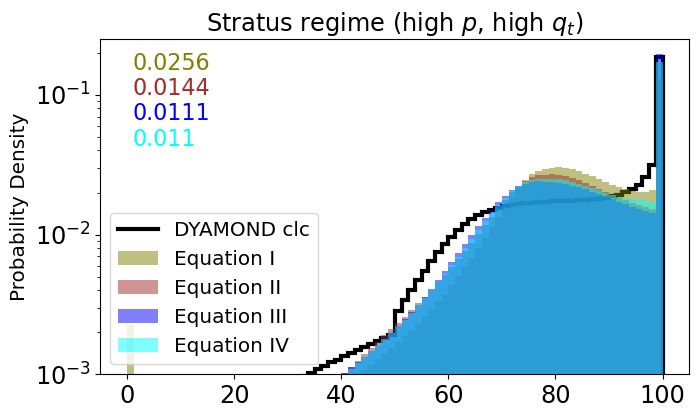

In [15]:
# Increase the general font size
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'xx-large'
mpl.rcParams['ytick.labelsize'] = 'xx-large'

plt.figure(figsize=(7.6, 4.35))
# plt.suptitle("Distributions on all validation data vs on the subset", fontsize=18, y=.91)

plot_titles = ['Cirrus regime (low $p$, low $q_t$)', 'Cumulus regime (high $p$, low $q_t$)', \
               'Deep convective regime (low $p$, high $q_t$)', 'Stratus regime (high $p$, high $q_t$)']

plot_title = plot_titles[regime - 1]

hist_data = {}
hist_preds = {}

axes = (0)

# Add new subplot iteratively
ax = plt.subplot(1, 1, 1)

BINS = 80
assert BINS == 80

plt.title(plot_title)
hist_data = plt.stairs(d_wang['Data_reg_%d_x'%(regime - 1)], d_wang['Data_reg_%d_y'%(regime - 1)], linewidth=3, color='black')
hist_eq_1 = plt.hist(preds_eq_1, linewidth=4, color='olive', density=True, fill=True, alpha=.5, bins=BINS)
hist_eq_2 = plt.hist(preds_eq_2, linewidth=4, color='brown', density=True, fill=True, alpha=.5, bins=BINS)
hist_eq_3 = plt.hist(preds_eq_3, linewidth=4, color='blue', density=True, fill=True, alpha=.5, bins=BINS)
hist_eq_4 = plt.hist(preds_eq_4, linewidth=4, color='cyan', density=True, fill=True, alpha=.5, bins=BINS)

eq_1_hel = hellinger(hist_eq_1[0], d_wang['Data_reg_%d_x'%(regime - 1)])
eq_2_hel = hellinger(hist_eq_2[0], d_wang['Data_reg_%d_x'%(regime - 1)])
eq_3_hel = hellinger(hist_eq_3[0], d_wang['Data_reg_%d_x'%(regime - 1)])
eq_4_hel = hellinger(hist_eq_4[0], d_wang['Data_reg_%d_x'%(regime - 1)])

plt.rc('font', size=16)
plt.text(1, 0.22 - 0.07, np.round(eq_1_hel, 4), color='olive')
plt.text(1, 0.2 - 0.1, np.round(eq_2_hel, 4), color='brown')
plt.text(1, 0.18 - 0.114, np.round(eq_3_hel, 4), color='blue')
plt.text(1, 0.16 - 0.117, np.round(eq_4_hel, 4), color='cyan')
plt.rc('font', size=10)

ax.legend(['DYAMOND clc', 'Equation I', 'Equation II', 'Equation III', 'Equation IV'], loc='lower left')

plt.ylabel('Probability Density')
# plt.ylim((0, 0.25))
plt.yscale('log')
plt.ylim([0.001, 0.25])
    
plt.savefig('regime_%d/evaluate_eqns.pdf'%regime)

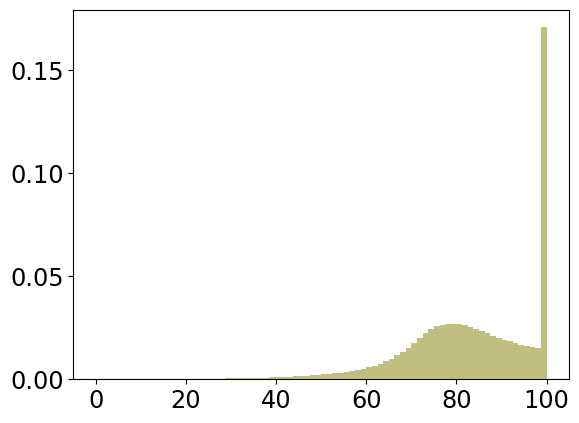

In [26]:
hist_eq_2 = plt.hist(preds_eq_2, linewidth=4, color='olive', density=True, fill=True, alpha=.5, bins=BINS)

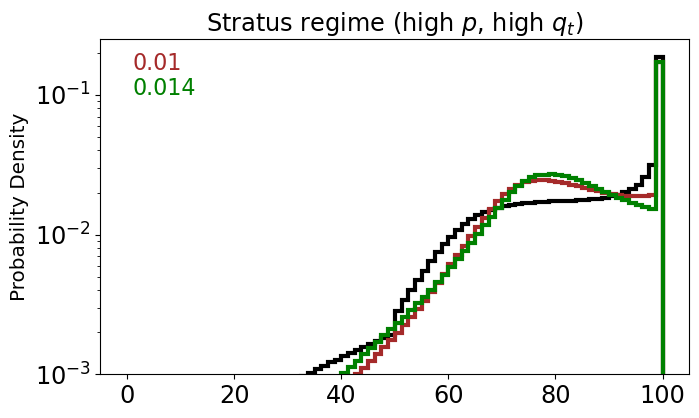

In [28]:
# Increase the general font size
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'xx-large'
mpl.rcParams['ytick.labelsize'] = 'xx-large'

plt.figure(figsize=(7.6, 4.35))
# plt.suptitle("Distributions on all validation data vs on the subset", fontsize=18, y=.91)

plot_titles = ['Cirrus regime (low $p$, low $q_t$)', 'Cumulus regime (high $p$, low $q_t$)', \
               'Deep convective regime (low $p$, high $q_t$)', 'Stratus regime (high $p$, high $q_t$)']

plot_title = plot_titles[regime - 1]

hist_data = {}
hist_preds = {}

axes = (0)

# Add new subplot iteratively
ax = plt.subplot(1, 1, 1)

BINS = 80
assert BINS == 80

plt.title(plot_title)
hist_data = plt.stairs(d_wang['Data_reg_%d_x'%(regime - 1)], d_wang['Data_reg_%d_y'%(regime - 1)], linewidth=3, color='black')
hist_pysr = plt.stairs(d_pysr['Preds_reg_%d_x'%(regime - 1)], d_pysr['Preds_reg_%d_y'%(regime - 1)], linewidth=3, color='brown')
plt.stairs(hist_eq_2[0], hist_eq_2[1], linewidth=3, color='green')
# hist_eq_2 = plt.hist(preds_eq_2, linewidth=4, color='brown', density=True, fill=True, alpha=.5, bins=BINS)
# hist_eq_3 = plt.hist(preds_eq_3, linewidth=4, color='blue', density=True, fill=True, alpha=.5, bins=BINS)
# hist_eq_4 = plt.hist(preds_eq_4, linewidth=4, color='cyan', density=True, fill=True, alpha=.5, bins=BINS)

eq_2_hel = hellinger(hist_eq_2[0], d_wang['Data_reg_%d_x'%(regime - 1)])
# eq_2_hel = hellinger(hist_eq_2[0], d_wang['Data_reg_%d_x'%(regime - 1)])
# eq_3_hel = hellinger(hist_eq_3[0], d_wang['Data_reg_%d_x'%(regime - 1)])
# eq_4_hel = hellinger(hist_eq_4[0], d_wang['Data_reg_%d_x'%(regime - 1)])

plt.rc('font', size=16)
plt.text(1, 0.22 - 0.07, 0.01, color='brown')
plt.text(1, 0.2 - 0.1, np.round(eq_2_hel, 3), color='green')
# plt.text(7, 0.18 - 0.114, np.round(eq_3_hel, 3), color='blue')
# plt.text(7, 0.16 - 0.117, np.round(eq_4_hel, 3), color='cyan')
plt.rc('font', size=10)

# ax.legend(['DYAMOND clc', 'PySR equation', 'Regime-specific (PySR) eq.'])

plt.ylabel('Probability Density')
# plt.ylim((0, 0.25))
plt.yscale('log')
plt.ylim([0.001, 0.25])
    
plt.savefig('regime_%d/evaluate_eqns_one_eq.pdf'%regime)

**Print equations**

In [16]:
def round_expr(expr, num_digits=2):
    def format_number(n):
        if isinstance(n, (int, float)):
            return '{:.{}e}'.format(n, num_digits)
        elif isinstance(n, sp.Number):
            return '{:.{}e}'.format(n.evalf(), num_digits)
        else:
            return n

    converted_expr = expr.xreplace({
        n: sp.sympify(format_number(n)) for n in expr.atoms()
    })
    return converted_expr

dig = 3

In [17]:
# Equation 1
sp.simplify(eq_1.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

305.898379737669*RH + 56737373.3394015*RH_z**2 + 5403.6682425153*RH_z - 204.688242792686

In [18]:
round_expr(sp.simplify(eq_1.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

305.9*RH + 5404.0*RH_z + 56740000.0*RH_z**2.0 - 204.7

In [19]:
# Equation 2
sp.simplify(eq_2.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

39309287.4845682*RH_z**2 + 3743.81709822216*RH_z + 7.22147324788826*exp(3.00756750601811*RH) - 38.6392537016008

In [20]:
round_expr(sp.simplify(eq_2.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

3744.0*RH_z + 39310000.0*RH_z**2.0 + 7.221*exp(3.008*RH) - 38.64

In [21]:
# Equation 3
sp.simplify(eq_3.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

(RH + 0.507764324487295)**3*(81.8203882796247*RH - 49.2977849291041) - (-9901.25600014303*RH_z + 400716.975635751*RH_zz + 1.1304425938)*(3874.99126286345*RH_z - 400716.975635751*RH_zz + (3.00756750601811*RH - 1.81209621695678)*(3874.99126286345*RH_z + 0.184527111449995) + 0.131533674697167)

In [22]:
round_expr(sp.simplify(eq_3.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

(RH + 0.5078)**3.0*(81.82*RH - 49.3) - 1.0*(-9901.0*RH_z + 400700.0*RH_zz + 1.13)*(3875.0*RH_z - 400700.0*RH_zz + (3.008*RH - 1.812)*(3875.0*RH_z + 0.1845) + 0.1315)

In [23]:
# Equation 4
sp.simplify(eq_4.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

((3.00756750601811*RH - 1.81209621695678)*(15.2870685352109*p_zz + 0.0267450520432442) + (15.2870685352109*p_zz + 0.0267450520432442)*(17553.0168424461*q_c + 0.00370305317439029)*((RH + 0.509462673731254)**3*(81.8203882796247*RH - 49.2977849291041) - (-10381.9928412016*RH_z + 400716.975635751*RH_zz + 1.18923914878786)*(3874.99126286345*RH_z - 400716.975635751*RH_zz + (3.00756750601811*RH - 1.81209621695678)*(3874.99126286345*RH_z + 0.184527111449995) + 0.131533674697167)) - (88.3273124726362*p_zz + 0.00945011469478179)*(17553.0168424461*q_c + 0.00370305317439029))/((15.2870685352109*p_zz + 0.0267450520432442)*(17553.0168424461*q_c + 0.00370305317439029))

In [24]:
round_expr(sp.simplify(eq_4.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

((3.008*RH - 1.812)*(15.29*p_zz + 0.02675) + (15.29*p_zz + 0.02675)*(17550.0*q_c + 0.003703)*((RH + 0.5095)**3.0*(81.82*RH - 49.3) - 1.0*(-10380.0*RH_z + 400700.0*RH_zz + 1.189)*(3875.0*RH_z - 400700.0*RH_zz + (3.008*RH - 1.812)*(3875.0*RH_z + 0.1845) + 0.1315)) - 1.0*(88.33*p_zz + 0.00945)*(17550.0*q_c + 0.003703))/((15.29*p_zz + 0.02675)**1.0*(17550.0*q_c + 0.003703)**1.0)

In [36]:
# Total MSE
(245.54*58421418 + 277.76*35374362 + 107.28*35374356 + 88.35*58421401 + 0*97587934)/samples_total

# (58421418,)
# (35374362,)
# (35374356,)
# (58421401,)
# (97587934,)

116.16147076433901